<a href="https://colab.research.google.com/github/TheoLequy/HappinessHackers/blob/main/DataAnalysis_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# XGBoost is typically the best for a lot of this kind of stuff (https://dataaspirant.com/xgboost-algorithm/)
# google xgboost kaggle and youll see what i mean
!pip install xgboost

In [207]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

# Rest of everything we use will probably be sklearn cause its the easiest to use
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
# Clone the github repo with all the data
# !git clone https://github.com/SamuelMoor-Smith/happiness-hacking.git

# upload final_dataset.csv manually

Cloning into 'happiness-hacking'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 41 (delta 5), reused 29 (delta 2), pack-reused 0
Receiving objects: 100% (41/41), 3.17 MiB | 5.28 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
# Change to this directory
%cd happiness-hacking

# List the files
!ls

/content/happiness-hacking
data  final_dataset_2018.csv  ourworldindata  README.md


In [70]:
df = pd.read_csv('final_dataset (2).csv')  # Opens the 2015 data for example

print(df.head())
print(df.info())

  code  year  happiness  food_insec  precipitation  indiv_free  gini    hdi  \
0  AFG  2022     1.8590    4.958000         25.244       0.015   NaN  0.479   
1  AFG  2021     2.4038    4.958000         26.314       0.137   NaN  0.478   
2  AFG  2020     2.5229    5.052838         26.026       0.417   NaN  0.483   
3  AFG  2019     2.5669    4.958000         25.754       0.365   NaN  0.488   
4  AFG  2018     3.2033    4.949788         25.495       0.381   NaN  0.483   

   gdp_pc     family  ...  air_deaths  life_expectancy  temperature  \
0   6.037  18.004000  ...       327.0            0.038     8.587000   
1   6.037  18.004000  ...       327.0            0.175     8.587000   
2   6.037  18.004000  ...       327.0            0.560     6.760211   
3   5.960  16.609505  ...       327.0            0.517     8.362843   
4   5.910  16.527699  ...       327.0            0.558     9.173828   

   urbanization  covid          hri  suicides    taxes  schooling  death_rate  
0           NaN   

In [246]:
COUNTRY_LABEL = "code"
HAPPINESS_LABEL = "happiness"
# Sets x data to be everything except happiness rank and score
# (country and region are removed because they are non-numeric but could be added in with some proprocessing)
X_with_labels = df.drop(["code", "year", "happiness"], axis=1)
y = df["happiness"]

# This cell imputes the data and then scales the data to be normally distributed with mean 0 and standard variance
# helps a lot with linear regression but probs wont make too much of a difference in ensemble methods
# Create a pipeline with imputation and scaling
data_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values using the mean
    ('scaler', StandardScaler())  # Scale data
])

X = data_preprocessing.fit_transform(X_with_labels)
codes = np.array(df["code"].drop_duplicates())


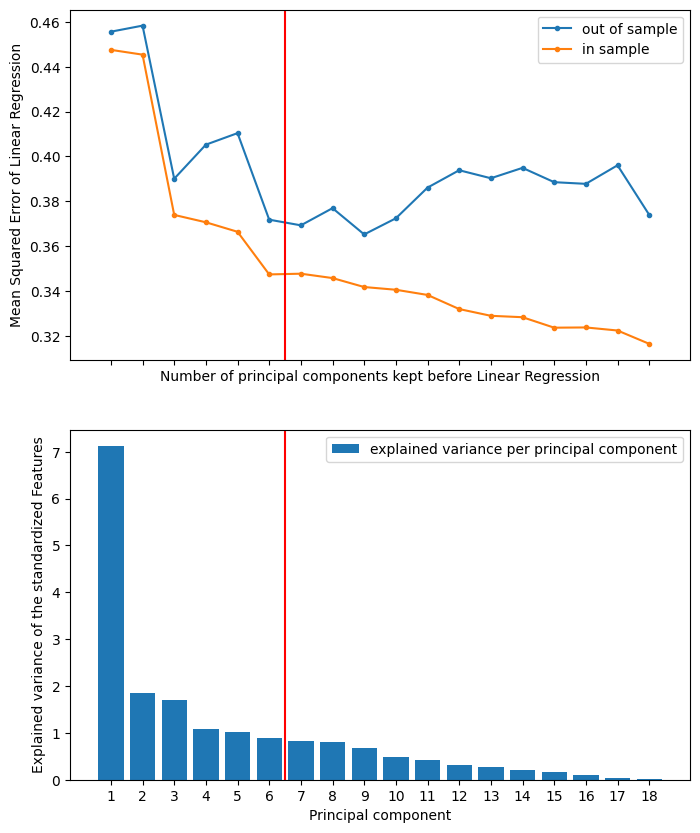

In [247]:
# determining best number of pca components

kf = KFold(n_splits=5, shuffle=True)
n_feat = len(X_with_labels.columns)
n_comps = range(1,n_feat+1)
principal_variance = np.zeros(len(n_comps))
errors = np.ones((len(n_comps), 2))
lin_reg_coefs = np.zeros(n_feat)
for n in n_comps:
  pca = PCA(n_components=n)
  X_pca = pca.fit_transform(X)
  if n == n_feat:
    principal_variance = pca.explained_variance_

  model = LinearRegression() #, XGBRegressor(objective='reg:squarederror', n_estimators=100)]
  mse_in_sample = []
  mse_out_sample = []
  for train_country_index, val_country_index in kf.split(codes):

    # Split the dataset into training and validation sets based on countries
    train_index = df["code"].isin(codes[train_country_index])
    val_index = df["code"].isin(codes[val_country_index])
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)

    mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
    mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))
  errors[n-1, 0] = np.mean(mse_in_sample)
  errors[n-1, 1] = np.mean(mse_out_sample)



fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8,10))
ax1.plot(n_comps, errors[:,1], '.-', label='out of sample')
ax1.plot(n_comps, errors[:,0], '.-', label='in sample')
ax2.bar(n_comps, principal_variance, label='explained variance per principal component')
ax1.set_xlabel("Number of principal components kept before Linear Regression")
ax1.set_ylabel("Mean Squared Error of Linear Regression")
ax1.axvline(6.5, c='r')
ax2.axvline(6.5, c='r')
ax2.set_ylabel("Explained variance of the standardized Features")
ax2.set_xlabel("Principal component")
ax2.set_xticks(n_comps)
ax1.legend()
ax2.legend()

Text(0, 0.5, 'coefficient for linear regression with n principal components')

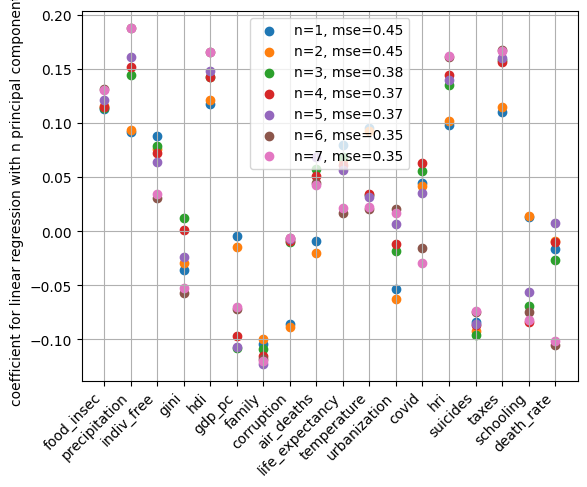

In [248]:
fig, ax = plt.subplots()
plt.grid()
for n in range(1,8):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)

    principal_variance = pca.explained_variance_

    model = LinearRegression() #, XGBRegressor(objective='reg:squarederror', n_estimators=100)]

    model.fit(X_pca, y)

    mse = mean_squared_error(model.predict(X_pca), y)
    expl_var = explained_variance_score(model.predict(X_pca), y)

    lin_reg_coefs = pca.inverse_transform(model.coef_)

    feature_labels = X_with_labels.columns.values
    ax.scatter(feature_labels, lin_reg_coefs, label=f"n={n}, mse={mse:.2f}")



plt.xticks(rotation=45, ha='right')
plt.legend()
ax.set_ylabel("coefficient for linear regression with n principal components")

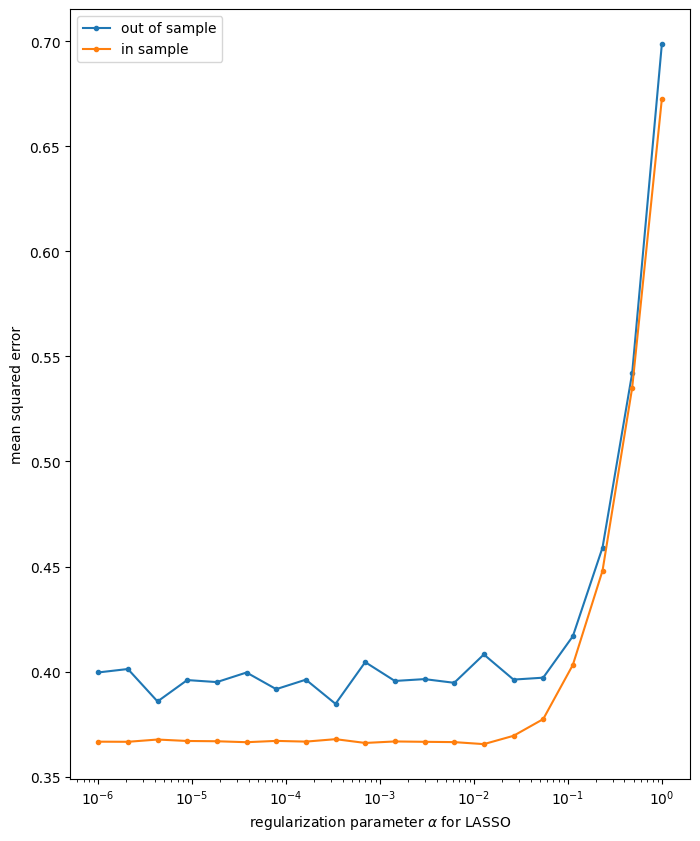

In [242]:
# determining best lasso regularization parameter

kf = KFold(n_splits=5, shuffle=True)
n_feat = len(X_with_labels.columns)
alphas = np.logspace(-6, 0,20)

errors = np.ones((len(alphas), 2))
lin_reg_coefs = np.zeros(n_feat)
for i, a in enumerate(alphas):
  model = Lasso(alpha=a)
  mse_in_sample = []
  mse_out_sample = []
  for train_country_index, val_country_index in kf.split(codes):

    # Split the dataset into training and validation sets based on countries
    train_index = df["code"].isin(codes[train_country_index])
    val_index = df["code"].isin(codes[val_country_index])
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)

    mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
    mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))
  errors[i, 0] = np.mean(mse_in_sample)
  errors[i, 1] = np.mean(mse_out_sample)



fig, ax = plt.subplots(figsize=(8,10))
ax.plot(alphas, errors[:,1], '.-', label='out of sample')
ax.plot(alphas, errors[:,0], '.-', label='in sample')
ax.set_xlabel(r"regularization parameter $\alpha$ for LASSO")
ax.set_ylabel("mean squared error")
ax.set_xscale("log")
ax.legend()


Text(0, 0.5, 'coefficient for LASSO with $\\alpha = 0.1$')

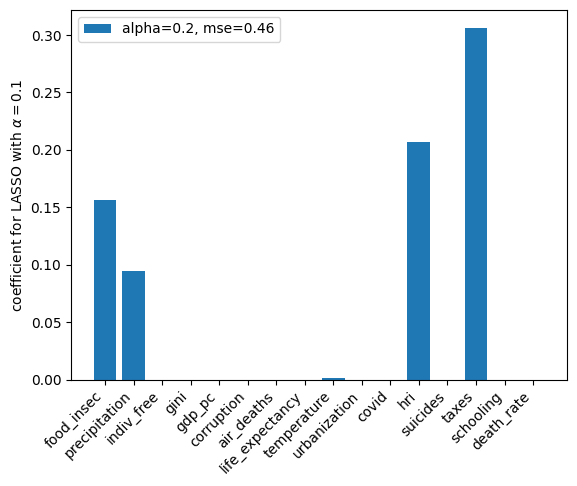

In [245]:
a = 0.03
model = Lasso(alpha=a)
model.fit(X, y)

mse = mean_squared_error(model.predict(X), y)
expl_var = explained_variance_score(model.predict(X), y)

lin_reg_coefs = model.coef_

feature_labels = X_with_labels.columns.values

fig, ax = plt.subplots()
ax.bar(feature_labels, lin_reg_coefs, label=f"alpha={a}, mse={mse:.2f}")
plt.xticks(rotation=45, ha='right')
plt.legend()
ax.set_ylabel(r"coefficient for LASSO with $\alpha = 0.1$")



In [94]:
# Adding back 'Country' and 'Region' for interpretation
results = X_test.copy()
results.insert(0, COUNTRY_LABEL, df.loc[test_indices, COUNTRY_LABEL])
# results['Actual Rank'] = y_test['Happiness Rank']
# results['Predicted Rank'] = y_pred[:, 0]
results['Actual Score'] = y_test[HAPPINESS_LABEL]
results['Predicted Score'] = y_pred

# print(results[['Country', 'Region', 'Actual Rank', 'Predicted Rank', 'Actual Score', 'Predicted Score']].head())
# print(results)
print(results[[COUNTRY_LABEL, 'Actual Score', 'Predicted Score']].head())

print("\n")

linear_feature_importance = model.coef_

# For a multi-output model, you'll get a coefficient array for each output
print("Linear Regression Feature Importance (Coefficients):")
for i, name in enumerate(X.columns):
    # print(f"{name}: {linear_feature_importance[0][i]}")  # Adjust indexing for multi-output
    print(f"Absolute Value (magnitude of effect) {name}: {linear_feature_importance[0][i]}")  # Adjust indexing for multi-output

     code  Actual Score  Predicted Score
60    AUS      7.272100         6.756486
157   BIH      5.129400         5.333783
876   MUS      5.648000         5.880979
1115  POL      5.803043         5.878998
1071  PAN      6.430000         6.179993


Linear Regression Feature Importance (Coefficients):
Absolute Value (magnitude of effect) food_insec: 0.16963304911259972
Absolute Value (magnitude of effect) precipitation: 0.09844746030640289
Absolute Value (magnitude of effect) indiv_free: -0.4318361592581756
Absolute Value (magnitude of effect) gini: -0.014697984831560092
Absolute Value (magnitude of effect) hdi: 0.15144515072909323
Absolute Value (magnitude of effect) gdp_pc: -0.09487795321566263
Absolute Value (magnitude of effect) family: -0.20339926177370457
Absolute Value (magnitude of effect) corruption: -0.007241858259895563
Absolute Value (magnitude of effect) air_deaths: 0.10639916153196784
Absolute Value (magnitude of effect) life_expectancy: 0.3544243331707627
Absolute Value (m

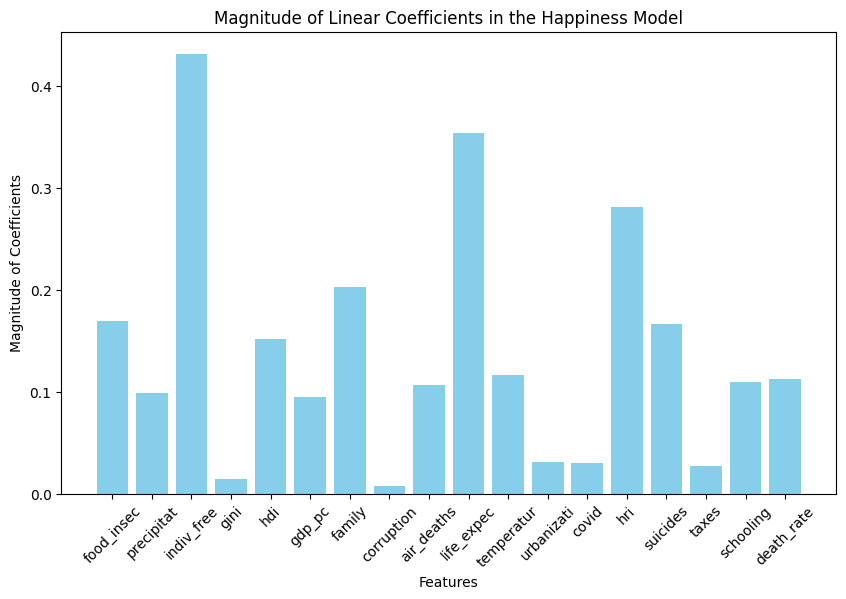

In [95]:
# Assuming 'model' is your trained Linear Regression model
# and 'X_train' is your training dataset
feature_names = [name[:10] for name in X_train.columns]
coefficients = model.coef_.flatten()  # Flatten the coefficients if necessary

# Calculate the magnitude of each coefficient
coeff_magnitudes = [abs(coef) for coef in coefficients]

# Create a bar plot for the coefficients
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coeff_magnitudes, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Magnitude of Coefficients')
plt.title('Magnitude of Linear Coefficients in the Happiness Model')
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.show()

In [90]:
# Now try with xgboost

# Initialize XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Fit the model on the training data
# For this example, we'll only predict the 'Happiness Score', hence `y_train['Happiness Score']`
xgb_model.fit(X_train, y_train[HAPPINESS_LABEL])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [91]:
# Predicting 'Happiness Score'
y_pred_score = xgb_model.predict(X_test)

# Calculate MSE for 'Happiness Score'
mse_score_xgb = mean_squared_error(y_test[HAPPINESS_LABEL], y_pred_score)
print(f'Mean Squared Error for Happiness Score with XGBoost: {mse_score_xgb}')

Mean Squared Error for Happiness Score with XGBoost: 0.13158177412214517


In [92]:
# Display results for XGBoost

results = X_test.copy()
results.insert(0, COUNTRY_LABEL, df.loc[test_indices, COUNTRY_LABEL])
# results['Actual Rank'] = y_test['Happiness Rank']
# results['Predicted Rank'] = y_pred[:, 0]
results['Actual Score'] = y_test[HAPPINESS_LABEL]
results['Predicted Score'] = y_pred

# print(results[['Country', 'Region', 'Actual Rank', 'Predicted Rank', 'Actual Score', 'Predicted Score']].head())
# print(results)
print(results[[COUNTRY_LABEL, 'Actual Score', 'Predicted Score']].head())

print("\n")

xgboost_feature_importance = xgb_model.feature_importances_

print("XGBoost Feature Importance:")
for importance, name in sorted(zip(xgboost_feature_importance, X.columns), reverse=True):
    print(f"{name}: {importance}")

     code  Actual Score  Predicted Score
60    AUS      7.272100         6.756486
157   BIH      5.129400         5.333783
876   MUS      5.648000         5.880979
1115  POL      5.803043         5.878998
1071  PAN      6.430000         6.179993


XGBoost Feature Importance:
hri: 0.5295506119728088
taxes: 0.13178490102291107
family: 0.07900926470756531
hdi: 0.06916557997465134
urbanization: 0.0323345810174942
air_deaths: 0.029081929475069046
gdp_pc: 0.020103299990296364
food_insec: 0.016928408294916153
gini: 0.015488271601498127
corruption: 0.014515897259116173
precipitation: 0.010461084544658661
temperature: 0.009656046517193317
suicides: 0.008439249359071255
schooling: 0.007891213521361351
indiv_free: 0.006909165531396866
death_rate: 0.0068681552074849606
covid: 0.005935171153396368
life_expectancy: 0.005877180956304073


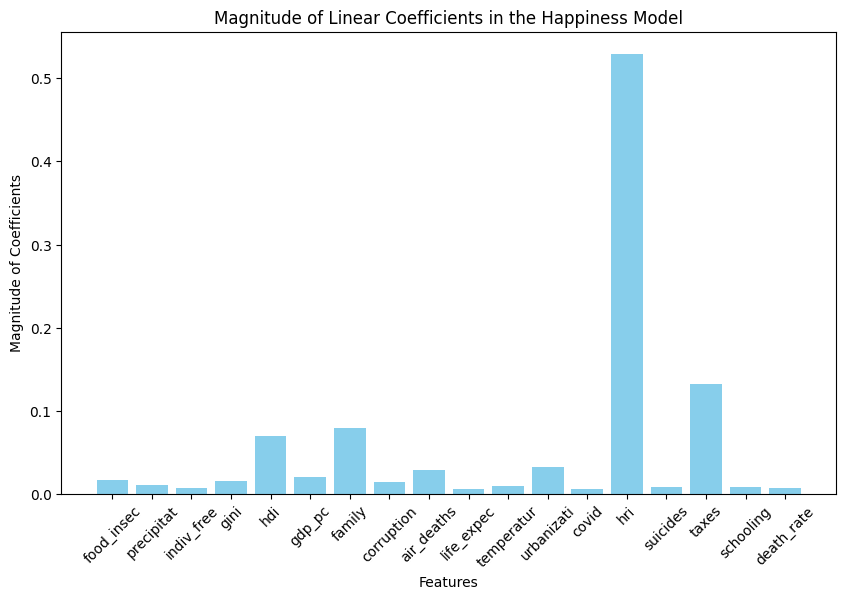

In [93]:
# Assuming 'xgb_model' is your trained XGBoost model and 'X_train' contains your feature names
feature_names = [name[:10] for name in X_train.columns]
coefficients = model.coef_.flatten()  # Flatten the coefficients if necessary

# Calculate the magnitude of each coefficient
coeff_magnitudes = [abs(coef) for coef in xgboost_feature_importance]

# Create a bar plot for the coefficients
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coeff_magnitudes, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Magnitude of Coefficients')
plt.title('Magnitude of Linear Coefficients in the Happiness Model')
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load the data from CSV
df = pd.read_csv('final_dataset.csv')  # Replace 'your_data.csv' with your actual CSV file path

# Extract labels from the DataFrame
labels = df['code']  # Replace 'label_column' with the name of your label column

# Exclude label column and any other non-feature columns from PCA
X = df.drop(columns=['code','happiness','year'])  # Replace 'non_feature_column1', 'non_feature_column2', etc. with any other non-feature columns


data_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values using the mean
    ('scaler', StandardScaler())  # Scale data
])
X = data_preprocessing.fit_transform(X)




# Apply PCA
pca = PCA()  # You can adjust the number of components as needed
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=X_pca)

principal_components = pca.components_
principal_variance = pca.explained_variance_

fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)
xx = xx = df.drop(columns=['code','happiness','year']).columns.values
#plt.bar(np.linspace(0,len(principal_variance),len(principal_variance)),principal_variance)
ax1.bar(xx , principal_components[0])
#plt.bar(np.linspace(0,len(principal_variance),len(principal_variance)),principal_variance)
ax1.bar(xx , principal_components[0])
ax2.bar(xx , principal_components[1])
ax3.bar(xx , principal_components[2])

The coefficients basically tell you how important each feature was in the detrmination

I guess in this case the linear regression is better, but I think this is mainly because of the fact that our data is actually linear -- the sum of all columns is the score...